In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

In [3]:
plt.rc('lines', linewidth=2, markersize=10)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})

In [4]:
from scem import gen, stein, kernel, ebm
from scem import util
import torch

In [5]:
seed = 13
torch.manual_seed(seed)
n = 300
neval = 1000
dx = 5
dz = 3
W = torch.randn([dx, dz]) / (dx * dz)**0.5
b = torch.randn([dx, ])
c = torch.randn([dz, ])
grbm = ebm.GaussianRBM(W, b, c)

In [6]:
X = grbm.sample(n, n_burnin=500)
Xeval = grbm.sample(neval, n_burnin=500, seed=seed+14)

In [7]:
# define kernels
med2 = util.pt_meddistance(X)**2
kx = kernel.KIMQ(b=-0.5, c=1, s2=med2)
#kx = kernel.KGauss(torch.tensor([med2]))

In [8]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)
        m.bias.data.fill_(0.)

In [9]:
# q(z|x)
cs = gen.CSGRBMBernoulliFamily(dx, dz)
cs.apply(init_weights)

CSGRBMBernoulliFamily(
  (probs): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
      (1): Softmax(dim=-1)
    )
    (1): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
      (1): Softmax(dim=-1)
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=2, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

In [10]:
# optimizer settings
learning_rate_q = 1e-2
weight_decay_q = 1e-2
optimizer_q = torch.optim.Adam(cs.parameters(), lr=learning_rate_q,
                               weight_decay=weight_decay_q)

In [11]:
W0 = torch.ones([dx, dz])
b0 = torch.zeros([dx,])
c0 = torch.ones([dz,])
p = ebm.GaussianRBM(W0, b0, c0)

In [12]:
# optimizer settings
learning_rate_p = 1e-2
weight_decay_p = 1e-2
optimizer_p = torch.optim.Adam(p.parameters(), lr=learning_rate_p,
                               weight_decay=weight_decay_p)

In [13]:
iter_q = 10
iter_p = 300

In [14]:
approx_score = stein.ApproximateScore(
        p.score_joint_obs, cs)
approx_score.n_sample = 500

In [15]:
true_train_loss = torch.empty([iter_p])
true_eval_loss = torch.empty([iter_p])
approx_train_loss = torch.empty([iter_p])
grad_loss_pq = torch.empty([iter_p])
params = {
    'W': torch.empty([iter_p, dx, dz]), 
    'b': torch.empty([iter_p, dx]),
    'c': torch.empty([iter_p, dz]),
}

In [16]:
kz = kernel.OHKGauss(2, torch.tensor([1.*dz]))

def inner_loop(niter):
    for i in range(niter):
        Z = cs.sample(1, X, seed+i).squeeze(0)
        loss = stein.kcsd_ustat(
            X, Z, p.score_joint_latent, kx, kz)
        optimizer_q.zero_grad()
        loss.backward(retain_graph=False)
        optimizer_q.step()

In [17]:
for t in range(iter_p):
    inner_loop(iter_q)
    loss = stein.ksd_ustat(X, approx_score, kx)
    ksd_true = stein.ksd_ustat(X, p.score_marginal_obs, kx).item()
    ksd_eval_true = stein.ksd_ustat(Xeval, p.score_marginal_obs, kx).item()
    
    true_train_loss[t] = ksd_true
    approx_train_loss[t] = loss.item()
    true_eval_loss[t] = ksd_eval_true
    
    if (t%10 == 0):
        print(loss, ksd_true, ksd_eval_true)
    
    optimizer_p.zero_grad()
    loss.backward(retain_graph=False)
    optimizer_p.step()

    params['W'][t] = p.W.data
    params['b'][t] = p.b.data
    params['c'][t] = p.c.data

tensor(10.2978, grad_fn=<DivBackward0>) 9.56113338470459 10.309452056884766
tensor(7.7106, grad_fn=<DivBackward0>) 7.602195739746094 8.224462509155273
tensor(5.9143, grad_fn=<DivBackward0>) 5.797239303588867 6.309599876403809
tensor(4.3859, grad_fn=<DivBackward0>) 4.454642295837402 4.8842854499816895
tensor(3.3611, grad_fn=<DivBackward0>) 3.45609974861145 3.818495512008667
tensor(2.6346, grad_fn=<DivBackward0>) 2.6977384090423584 3.001955270767212
tensor(2.0511, grad_fn=<DivBackward0>) 2.1222689151763916 2.3771779537200928
tensor(1.5600, grad_fn=<DivBackward0>) 1.6903280019760132 1.9054453372955322
tensor(1.2290, grad_fn=<DivBackward0>) 1.370064377784729 1.5541086196899414
tensor(1.0036, grad_fn=<DivBackward0>) 1.1334308385849 1.2924273014068604
tensor(0.8278, grad_fn=<DivBackward0>) 0.9573758244514465 1.0959645509719849
tensor(0.7139, grad_fn=<DivBackward0>) 0.8253889083862305 0.9472781419754028
tensor(0.6151, grad_fn=<DivBackward0>) 0.726534366607666 0.8351432681083679
tensor(0.5510,

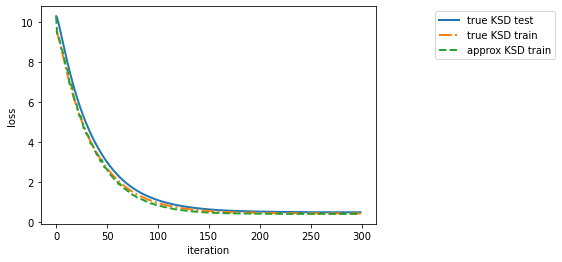

In [18]:
plt.plot(np.arange(iter_p), true_eval_loss[:iter_p].detach().numpy(), '-', label='true KSD test')
plt.plot(np.arange(iter_p), true_train_loss[:iter_p].detach().numpy(), '-.',label='true KSD train')
plt.plot(np.arange(iter_p), approx_train_loss[:iter_p].detach().numpy(), '--', label='approx KSD train')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(1.55, 1), loc='upper right')
plt.savefig('ppca_training.png', bbox_inches='tight')

In [19]:
p_weight_history = np.array([params['W'][i].detach().numpy() for i in range(iter_p)])

In [26]:
p_weight_history[-1]

array([[ 0.1853084 ,  0.17602916,  0.18176012],
       [ 0.35576212,  0.40707085,  0.3921723 ],
       [-0.16067089, -0.1784436 , -0.16901207],
       [ 0.3108724 ,  0.3050842 ,  0.3086138 ],
       [ 0.6633023 ,  0.72695976,  0.7199241 ]], dtype=float32)

In [28]:
p.b - 

tensor([-0.2662, -0.3046,  0.3600, -0.3395, -1.0416], grad_fn=<SubBackward0>)

In [22]:
W

tensor([[-0.0288, -0.2958,  0.3641],
        [ 0.3525,  0.2893, -0.2484],
        [-0.0876,  0.1893,  0.3924],
        [ 0.0600,  0.0055, -0.1840],
        [ 0.1006, -0.1737, -0.1821]])

In [24]:
stein.ksd_ustat(Xeval, grbm.score_marginal_obs, kx).item()

0.4304715394973755

In [25]:
stein.ksd_ustat(Xeval, p.score_marginal_obs, kx).item()

0.48903536796569824